In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertConfig, BertForTokenClassification

In [3]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
ids_to_labels = {0: 'Ｘ', 1: 'Ｏ', -100:'IGN'}
labels_to_ids = {'Ｘ': 0, 'Ｏ': 1, 'IGN':-100}

In [5]:
ids_to_labels

{0: 'Ｘ', 1: 'Ｏ', -100: 'IGN'}

In [6]:
labels_to_ids

{'Ｘ': 0, 'Ｏ': 1, 'IGN': -100}

In [7]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 1
EPOCHS = 2
LEARNING_RATE = 1e-05
MAX_GRAD_NORM = 10
tokenizer = BertTokenizerFast.from_pretrained('cl-tohoku/bert-large-japanese')

In [8]:
vocab = tokenizer.get_vocab()
re_vocab = {vocab[word]:word for word in vocab}

In [9]:
with open('wiki_Tari_tag_all.txt', 'r') as filein:
    wiki_tag = filein.readlines()
    filein.close()

In [10]:
wiki_tag_all = [''.join(wiki_tag[i].strip()) for i in range(len(wiki_tag))]

In [11]:
wiki_tag_all[40000:40005]

['ＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸ',
 'ＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸ',
 'ＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸ',
 'ＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸ',
 'ＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸ']

In [12]:
from sklearn.model_selection import train_test_split
jp_train_tag, jp_test_tag = train_test_split(wiki_tag_all, random_state=55, train_size=0.7)

In [13]:
len(jp_train_tag)

49000

In [14]:
cnt = 0
for word in jp_train_tag:
    if 'Ｏ' in word:
        cnt = cnt+1
print(cnt)  

24489


In [15]:
len(jp_test_tag)

21000

In [16]:
cnt = 0
for word in jp_test_tag:
    if 'Ｏ' in word:
        cnt = cnt+1
print(cnt)  

10511


In [17]:
with open('wiki_Tari_pattern_all.txt', 'r') as filein:
    wiki_sent = filein.readlines()
    filein.close()

In [18]:
wiki_sent_all = [wiki_sent[i].strip() for i in range(len(wiki_sent))]

In [19]:
jp_train_texts, jp_test_texts = train_test_split(wiki_sent_all, random_state=55, train_size=0.7)

In [20]:
wiki_sent_all[40017:40020]

['近年では2006年トリノオリンピックのジャンプ競技で金メダルを獲得している。',
 'モータースポーツは、オーストリアで3番目に人気のあるスポーツである（スキーとサッカーに次ぐ）。',
 '数人のオーストリアのドライバーがF1で成功を収めている。']

In [20]:
data_sent =[wiki_sent_all[40019][word] for word in range(len(wiki_sent_all[40019]))]
data_label =[wiki_tag_all[40019][word] for word in range(len(wiki_tag_all[40019]))]

In [18]:
pd.set_option('display.max_columns', None)
pd.DataFrame([data_sent, data_label], index=["sent", "label"])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
sent,数,人,の,オ,ー,ス,ト,リ,ア,の,ド,ラ,イ,バ,ー,が,F,1,で,成,功,を,収,め,て,い,る,。
label,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ


In [184]:
text = []
for num in range(len(wiki_sent_all)):
    text.append(len(wiki_sent_all[num]))

In [195]:
text

[74,
 88,
 52,
 110,
 77,
 85,
 82,
 106,
 46,
 192,
 62,
 67,
 77,
 115,
 118,
 89,
 35,
 84,
 69,
 52,
 91,
 98,
 60,
 98,
 79,
 130,
 110,
 61,
 93,
 39,
 90,
 153,
 59,
 75,
 36,
 82,
 82,
 49,
 50,
 73,
 77,
 112,
 66,
 96,
 30,
 55,
 65,
 86,
 68,
 75,
 75,
 59,
 135,
 51,
 72,
 68,
 94,
 61,
 79,
 79,
 68,
 87,
 101,
 133,
 98,
 116,
 62,
 48,
 44,
 50,
 49,
 98,
 64,
 154,
 46,
 138,
 82,
 57,
 95,
 53,
 48,
 44,
 57,
 80,
 41,
 61,
 35,
 25,
 115,
 102,
 68,
 79,
 53,
 98,
 51,
 23,
 114,
 97,
 140,
 97,
 40,
 98,
 68,
 73,
 41,
 57,
 25,
 66,
 50,
 61,
 154,
 99,
 89,
 151,
 57,
 96,
 113,
 60,
 96,
 86,
 77,
 94,
 41,
 76,
 44,
 97,
 86,
 81,
 101,
 46,
 93,
 112,
 68,
 72,
 55,
 50,
 133,
 95,
 50,
 70,
 37,
 72,
 50,
 81,
 112,
 134,
 40,
 44,
 84,
 63,
 50,
 102,
 93,
 33,
 73,
 36,
 106,
 113,
 43,
 54,
 75,
 40,
 147,
 60,
 75,
 94,
 41,
 90,
 58,
 54,
 34,
 117,
 142,
 76,
 88,
 65,
 50,
 69,
 70,
 120,
 106,
 50,
 135,
 139,
 97,
 65,
 84,
 97,
 75,
 72,
 55,
 108,
 6

                  0
count  70000.000000
mean      64.957729
std       38.637470
min        2.000000
25%       39.000000
50%       57.000000
75%       82.000000
max      603.000000


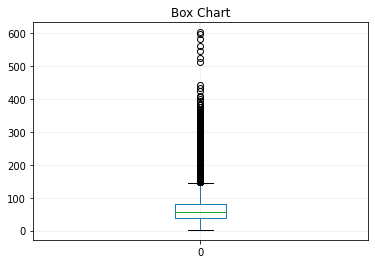

In [194]:
import pandas as pd
import matplotlib.pyplot as plt

# data = [1, 2, 3, 4, 5, 6, 7, 8]

df = pd.DataFrame(text)
print(df.describe())
df.plot.box(title="Box Chart")
plt.grid(linestyle="--", alpha=0.3)
plt.show()

In [18]:
jp_train_texts[0]

'ところが、2003年時点では輸出入とも相手国が分散する。'

In [19]:
tokenizer(wiki_sent_all[0])

{'input_ids': [2, 11668, 6307, 6244, 1785, 1559, 828, 4865, 4923, 1725, 1385, 893, 1846, 863, 6335, 4440, 3186, 3039, 932, 1040, 858, 12259, 828, 1719, 2000, 896, 1314, 3690, 4923, 932, 4823, 2678, 1390, 1985, 15554, 6157, 11229, 20529, 6335, 6461, 6416, 6456, 21606, 2044, 2678, 3228, 4865, 4923, 4908, 4323, 896, 1039, 3323, 932, 14675, 11263, 2664, 4049, 897, 6456, 6156, 3690, 24523, 11304, 829, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

## 檢查是否有None

In [20]:
for i in range(len(wiki_sent_all)):
    data_sent =[wiki_sent_all[i][word] for word in range(len(wiki_sent_all[i]))]
    data_label =[wiki_tag_all[i][word] for word in range(len(wiki_tag_all[i]))]
    pd.set_option('display.max_columns', None)
    if len(wiki_sent_all[i]) == len(wiki_tag_all[i]):
#         print(i,'OK')
        continue
    else:
        df = pd.DataFrame([data_sent, data_label], index=["sent", "label"])
        print(i)

In [45]:
wiki_sent_all[16:20]

['鑑賞とは音楽を聴いてそれを味わったり、価値を見極めたりすることである。',
 'リラックスしたり、エネルギーを増やしたり、思考を改善したり、その日のやる気を引き出したりする必要がある場合でも、明るい音楽は最も必要なときに追加のサポートを提供できる。',
 '縁故主義により経済的に成功したり、海外への留学を楽しんだりする高位聖職者や政府・軍高官の一族は「アガザデ」（高貴な生まれ）と呼ばれている。',
 '読んでいる途中で、難しい言葉の解説を行ったり、分かりにくい表現について内容をわかりやすく説明したりする。']

In [47]:
sent_try = [wiki_sent_all[16][word] for word in range(len(wiki_sent_all[16]))]
label_try = [wiki_tag_all[16][word] for word in range(len(wiki_tag_all[16]))]
df = pd.DataFrame([sent_try, label_try], index=["sent", "label"])
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
sent,鑑,賞,と,は,音,楽,を,聴,い,て,そ,れ,を,味,わ,っ,た,り,、,価,値,を,見,極,め,た,り,す,る,こ,と,で,あ,る,。
label,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｏ,Ｏ,Ｏ,Ｏ,Ｏ,Ｘ,Ｘ,Ｘ,Ｘ,Ｏ,Ｏ,Ｏ,Ｏ,Ｏ,Ｏ,Ｏ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ


In [64]:
df.fillna('Ｘ')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213
sent,こ,の,結,果,、,例,え,ば,旧,暦,で,は,「,秋,」,で,あ,っ,た,「,文,月,（,7,月,）,」,が,新,暦,で,は,「,夏,」,に,な,っ,た,り,、,7,月,9,日,頃,か,ら,8,月,1,1,日,頃,ま,で,で,あ,っ,た,二,百,十,日,が,新,暦,9,月,1,日,に,な,っ,た,り,、,盆,の,節,会,を,行,う,時,期,が,地,域,に,よ,っ,て,新,暦,7,月,と,新,暦,8,月,に,別,れ,た,り,す,る,な,ど,、,月,遅,れ,に,よ,る,そ,れ,ま,で,の,慣,習,と,の,相,違,が,発,生,し,て,い,る,ほ,か,、,前,記,の,よ,う,な,元,々,の,中,国,風,の,定,義,も,絡,み,、,現,在,で,も,若,干,の,違,和,感,が,存,在,す,る,こ,と,か,ら,、,日,本,の,メ,デ,ィ,ア,で,は,「,暦,の,上,で,は,…,…,」,\t,と,前,置,き,し,て,説,明,さ,れ,る,こ,と,が,あ,る,。
label,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｏ,Ｏ,Ｏ,Ｏ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｏ,Ｏ,Ｏ,Ｏ,Ｏ,Ｏ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ


In [65]:
with open('check_Tari.txt', 'w') as fileout:
    for i in range(len(wiki_sent_all)):
        data_sent =[wiki_sent_all[i][word] for word in range(len(wiki_sent_all[i]))]
        data_label =[wiki_tag_all[i][word] for word in range(len(wiki_tag_all[i]))]
        pd.set_option('display.max_columns', None)
        dd = pd.DataFrame([data_sent, data_label], index=["sent", "label"])
        df = dd.fillna('Ｘ')
        answer = ''.join(df.loc['label'])
        fileout.write(answer+'\n')
fileout.close()

KeyboardInterrupt: 

---

In [21]:
class dataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        # step 1: get the sentence and word labels 
#         sentence = self.data.sentence[index].strip().split()
        sentence = [i for i in self.data.sentence[index]]
#         word_tag_n = [''.join(label) for label in word_labels[index]]
#         word_labels = self.data.word_labels[index].split() 
    
        word_labels = [j for j in self.data.word_labels[index]]    


        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             is_pretokenized=True, 
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [labels_to_ids[label] for label in word_labels] 

        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
            if mapping[0] == 0 and mapping[1] != 0:
                # overwrite label
                encoded_labels[idx] = labels[i]
                i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

    def __len__(self):
        return self.len

In [22]:
train_dataset = pd.DataFrame([jp_train_texts, jp_train_tag], index=["sentence", "word_labels"]).T
test_dataset = pd.DataFrame([jp_test_texts, jp_test_tag], index=["sentence", "word_labels"]).T

In [23]:
print("たり型 TRAIN Dataset: {}".format(train_dataset.shape))
print("たり型 TEST Dataset: {}".format(test_dataset.shape))
training_set = dataset(train_dataset, tokenizer, MAX_LEN)
testing_set = dataset(test_dataset, tokenizer, MAX_LEN)

たり型 TRAIN Dataset: (49000, 2)
たり型 TEST Dataset: (21000, 2)


In [24]:
training_set[0]

{'input_ids': tensor([   2,  890,  869,  927,  861,  828,   32,   30,   30,   33, 2181, 2754,
         3452,  888,  897, 5163, 1370, 1308,  890,  916, 3806, 2485, 1719,  861,
         1376, 2675,  875,  925,  829,    3,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0

In [25]:
for token, label in zip(tokenizer.convert_ids_to_tokens(training_set[0]["input_ids"]), training_set[0]["labels"]):
    print('{0:10}  {1}'.format(token, label))

[CLS]       -100
と           0
こ           0
ろ           0
か           0
、           0
2           0
0           0
0           0
3           0
年           0
時           0
点           0
て           0
は           0
輸           0
出           0
入           0
と           0
も           0
相           0
手           0
国           0
か           0
分           0
散           0
す           0
る           0
。           0
[SEP]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -

In [26]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params) ## **表示字典 一批取4
testing_loader = DataLoader(testing_set, **test_params)

In [25]:
model = BertForTokenClassification.from_pretrained('cl-tohoku/bert-large-japanese', num_labels=len(labels_to_ids))
model.to(device)

Some weights of the model checkpoint at cl-tohoku/bert-large-japanese were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'bert.embeddings.position_ids']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForToken

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32768, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-1

In [26]:
inputs = training_set[2]
input_ids = inputs["input_ids"].unsqueeze(0)
attention_mask = inputs["attention_mask"].unsqueeze(0)
labels = inputs["labels"].unsqueeze(0)

input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)
labels = labels.to(device)

outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
initial_loss = outputs[0]
initial_loss

tensor(1.3112, device='cuda:0', grad_fn=<NllLossBackward0>)

In [27]:
tr_logits = outputs[1]
tr_logits.shape

torch.Size([1, 128, 3])

In [28]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 1e-05
    weight_decay: 0
)

In [29]:
import warnings
warnings.filterwarnings('ignore')
# Defining the training function on the 80% of the dataset for tuning the bert model,
def train(epoch):
    tr_loss, tr_accuracy, tr_opt_acc = 0, 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_opt_zero_steps, tr_opt_steps = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    model.train()

    for idx, batch in enumerate(training_loader): # 一次取一批
#         print(idx)
#         if idx == 193:
#             print(batch['input_ids'])
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels) ## 輸入 算出損失值
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)

        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,) ## 算每一批預測值

        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))

        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)

        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
        
        tn, fp, fn, tp = confusion_matrix(labels.cpu().numpy(), predictions.cpu().numpy(), labels=[0, 1]).ravel()
        tmp_tr_opt_acc = tp/(fn+fp+tp)
        if np.isnan(tmp_tr_opt_acc) == True:
            tmp_tr_opt_acc = 1
            tr_opt_zero_steps += 1
        else:
            tr_opt_steps += 1
            tr_opt_acc += tmp_tr_opt_acc            
            
            if idx % 100==0:
                loss_step = tr_loss/nb_tr_steps
                print(f"Training loss per 100 training steps: {loss_step}")
                opt_acc_step = tr_opt_acc / tr_opt_steps
                print(f"Training Opt_acc epoch: {opt_acc_step}")
        
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )

        # backward pass
        optimizer.zero_grad() ## T度值 清空
        loss.backward() ## 反向回饋"修正權重"
        optimizer.step() ## 透過優化器(先算損失值得反向回饋)執行修正

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    tr_opt_acc = tr_opt_acc / tr_opt_steps
    
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")
    print(f"Training Opt_acc epoch: {tr_opt_acc}")
    print('tr_zero_steps:',tr_opt_zero_steps)
    print('tr_opt_steps:',tr_opt_steps)

In [30]:
for epoch in range(EPOCHS):
    print(f"Training epoch: {epoch + 1}")
    train(epoch)

Training epoch: 1
Training loss per 100 training steps: 1.419046401977539
Training Opt_acc epoch: 0.038461538461538464
Training loss per 100 training steps: 0.13490166590378463
Training Opt_acc epoch: 0.5546958837696521
Training loss per 100 training steps: 0.08476757900459247
Training Opt_acc epoch: 0.7150622410074727
Training loss per 100 training steps: 0.0647275033694084
Training Opt_acc epoch: 0.7771185800171692
Training loss per 100 training steps: 0.05537666761854308
Training Opt_acc epoch: 0.8130118672134662
Training loss per 100 training steps: 0.04896588730356845
Training Opt_acc epoch: 0.8343752005468914
Training loss per 100 training steps: 0.04405566850887688
Training Opt_acc epoch: 0.8484817971392932
Training loss per 100 training steps: 0.039971953419857716
Training Opt_acc epoch: 0.8605450136152235
Training loss per 100 training steps: 0.03474579202604125
Training Opt_acc epoch: 0.8795761331246403
Training loss per 100 training steps: 0.032541070489017374
Training Opt_a

In [46]:
def valid(model, testing_loader):
    # put model in evaluation mode
    model.eval()

    eval_loss, eval_accuracy, eval_precision, eval_f1, eval_recall, eval_opt_acc, eval_opt_acc_n = 0, 0, 0, 0, 0, 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    opt_zero_steps, opt_steps = 0, 0
    eval_preds, eval_labels = [], []

    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):

            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)

            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels)

            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)

            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels) 遮罩 不會取無用
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,) 取最大機率的標記 num_label就消失 每批有效字元標記

            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)

            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)

            eval_labels.extend(labels)
            eval_preds.extend(predictions)

            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            
            tn, fp, fn, tp = confusion_matrix(labels.cpu().numpy(), predictions.cpu().numpy(), labels=[0, 1]).ravel()
            tmp_eval_opt_acc = tp/(fn+fp+tp)
            if fp !=0 or fn !=0:
                for batch_id in range(len(ids.cpu().numpy())):
                    print('\n')
                    sent = []
                    for word_id in ids.cpu().numpy()[batch_id]:
                        sent.append(re_vocab[word_id])
                    print(''.join(sent))
            
            if np.isnan(tmp_eval_opt_acc) == True:
                tmp_eval_opt_acc = 1
                opt_zero_steps += 1
#                 print('opt_zero_steps:',opt_zero_steps)
            else:
                opt_steps += 1
                eval_opt_acc_n += tmp_eval_opt_acc
                
                if idx % 100==0:
                    loss_step = eval_loss/nb_eval_steps
                    print(f"Validation loss per 100 evaluation steps: {loss_step}")
                    opt_acc_step = eval_opt_acc_n / opt_steps
                    print(f"Validation Opt_acc epoch: {opt_acc_step}")
                
            eval_accuracy += tmp_eval_accuracy


    labels = [ids_to_labels[id.item()] for id in eval_labels]
    predictions = [ids_to_labels[id.item()] for id in eval_preds]
    print(eval_opt_acc_n)
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    eval_opt_acc_n = eval_opt_acc_n / opt_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")
    print(f"Validation Opt_Acc_n: {eval_opt_acc_n}")
    print('zero_steps:',opt_zero_steps)
    print('opt_steps:',opt_steps)
    

    return labels, predictions

In [32]:
import warnings
warnings.filterwarnings("ignore")
labels, predictions = valid(model, testing_loader)

Validation loss per 100 evaluation steps: 0.0014195917906276085
Validation Opt_acc epoch: 0.9934183463595228
Validation loss per 100 evaluation steps: 0.0016285872610224395
Validation Opt_acc epoch: 0.9935136292279149
Validation loss per 100 evaluation steps: 0.0027470051384489076
Validation Opt_acc epoch: 0.9894670681875763
Validation loss per 100 evaluation steps: 0.002515969748668695
Validation Opt_acc epoch: 0.9905349088174573
Validation loss per 100 evaluation steps: 0.0026360191157017107
Validation Opt_acc epoch: 0.988259368327214
Validation loss per 100 evaluation steps: 0.0026338864796612003
Validation Opt_acc epoch: 0.986960677648937
Validation loss per 100 evaluation steps: 0.002429869389852381
Validation Opt_acc epoch: 0.9872077944615569
Validation loss per 100 evaluation steps: 0.0023760501440838124
Validation Opt_acc epoch: 0.9873075052711299
Validation loss per 100 evaluation steps: 0.002270761346975466
Validation Opt_acc epoch: 0.9881409112803554
Validation loss per 100 

## 讀檔

In [27]:
import torch
device = torch.device("cuda")
model = BertForTokenClassification.from_pretrained('cl-tohoku/bert-large-japanese', num_labels=len(labels_to_ids))
# model.to(device)
model.load_state_dict(torch.load('model_Tari/pytorch_model.bin'))
model.to(device)
model.eval()

Some weights of the model checkpoint at cl-tohoku/bert-large-japanese were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'bert.embeddings.position_ids']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForToken

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32768, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-1

---

* 召使い役て現れ、物語を引っかき回したり、インナモラーティの恋の仲立ちをしたりする。(標記對，但沒有符合到正規式所要求的字 應該只要'回したり')
* かく乱したり凝縮核を投入したりすると、急に滴を生して飽和蒸気となる。(mecab斷錯，正規式判別不出來，但神經網路還可以 '乱したり')

In [32]:
sentence = "鑑賞とは音楽を聴いてそれを味わったり、価値を見極めたりすることである"

inputs = tokenizer([word for word in sentence],
                    is_pretokenized=True, 
                    return_offsets_mapping=True, 
                    padding='max_length', 
                    truncation=True, 
                    max_length=MAX_LEN,
                    return_tensors="pt")

# move to gpu
ids = inputs["input_ids"].to(device)
mask = inputs["attention_mask"].to(device)
# forward pass
outputs = model(ids, attention_mask=mask)
logits = outputs[0]

active_logits = logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size*seq_len,) - predictions at the token level

tokens = tokenizer.convert_ids_to_tokens(ids.squeeze().tolist())
token_predictions = [ids_to_labels[i] for i in flattened_predictions.cpu().numpy()]
wp_preds = list(zip(tokens, token_predictions)) # list of tuples. Each tuple = (wordpiece, prediction)

prediction = []
for token_pred, mapping in zip(wp_preds, inputs["offset_mapping"].squeeze().tolist()):
    #only predictions on first word pieces are important
    if mapping[0] == 0 and mapping[1] != 0:
        prediction.append(token_pred[1])
    else:
        continue

# print(sentence.split())
print([word for word in sentence])
# print(inputs['input_ids'])
print(prediction)

['鑑', '賞', 'と', 'は', '音', '楽', 'を', '聴', 'い', 'て', 'そ', 'れ', 'を', '味', 'わ', 'っ', 'た', 'り', '、', '価', '値', 'を', '見', '極', 'め', 'た', 'り', 'す', 'る', 'こ', 'と', 'で', 'あ', 'る']
['Ｘ', 'Ｘ', 'Ｘ', 'Ｘ', 'Ｘ', 'Ｘ', 'Ｘ', 'Ｘ', 'Ｘ', 'Ｘ', 'Ｘ', 'Ｘ', 'Ｘ', 'Ｏ', 'Ｏ', 'Ｏ', 'Ｏ', 'Ｏ', 'Ｘ', 'Ｘ', 'Ｘ', 'Ｘ', 'Ｏ', 'Ｏ', 'Ｏ', 'Ｏ', 'Ｏ', 'Ｏ', 'Ｏ', 'Ｘ', 'Ｘ', 'Ｘ', 'Ｘ', 'Ｘ']


In [33]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.DataFrame([[word for word in sentence], prediction], index=["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
Tokens,鑑,賞,と,は,音,楽,を,聴,い,て,そ,れ,を,味,わ,っ,た,り,、,価,値,を,見,極,め,た,り,す,る,こ,と,で,あ,る
Tags,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｏ,Ｏ,Ｏ,Ｏ,Ｏ,Ｘ,Ｘ,Ｘ,Ｘ,Ｏ,Ｏ,Ｏ,Ｏ,Ｏ,Ｏ,Ｏ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ


In [34]:
inputs

{'input_ids': tensor([[   2, 5467, 5055,  890,  897, 5657, 3001,  932, 4345,  854,  888,  879,
          926,  932, 1595,  929,  885,  881,  924,  828, 1183, 1225,  932, 4847,
         2997,  915,  881,  924,  875,  925,  869,  890,  888,  852,  925,    3,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0,

In [36]:
import os

directory = "./model_Tari"

if not os.path.exists(directory):
    os.makedirs(directory)

# save vocabulary of the tokenizer
tokenizer.save_vocabulary(directory)
# save the model weights and its configuration file
model.save_pretrained(directory)
print('All files saved')
print('This tutorial is completed')

All files saved
This tutorial is completed
